# USD/MXN Exchange Rate during 2016 US Election Night - Under Construction

During the night of the 2016 US election night, we saw Donald Trump won the presidency while most polling agency predicted Hillary Clinton would be victorious. This came as a suprise to the most people. In this project I would like to how the financial market reacted during the election night.

## Background:
During the campaign Donald Trump repeatedly mentioned building a wall between the US and Mexico boarder, putting high import tariff on imported goods from Mexico and renegotiate or abandon NAFTA. All such action are seen as negatives for the Mexican economy whose biggest export market is the US. It is no suprise that in the event of a trump victory, the Mexican Peso will depreciate against other currencies.

In this project I will run a realtime analysis on Trumps victory chance and see how fast the financial market reacted as the result came out from each state.

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug  2 16:32:27 2017

@author: AlexH
"""

#Priors 1: state, number


#Updates & Results: state, time, number

#Step 1, get all data (use just website time info for now)

#Step 2, rolling regression

#Step 3, find error margin at each stage

#Step 4, compare with financial data
    

import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime
import matplotlib.dates as mdates
import pylab


### Getting the Data

The data is collected from the internet, polling data is from Fivethrityeight 'prior-538.csv' and the election realtime data is recorded by watching BBC/CNN election live broadcast 'results.csv'.

In [5]:
#%%
#Reading in data


# with open('data/prior_538.csv', newline='') as csvfile:
#     data = csv.reader(csvfile, delimiter=',')
#     prior=list(data)
prior = pd.read_csv('data/prior_538.csv')

prior = pd.DataFrame(prior)
prior.columns = ['State', 'poll_hc', 'poll_dt', 'poll_gj']
prior.State=[name.replace('-',' ') for name in prior.State]

#with open('call-AP.csv', newline='') as csvfile:
#    data = csv.reader(csvfile, delimiter=',')
#    call=list(data)
#
#call = pd.DataFrame(call)
#call.columns = ['State', 'result', 'time']

with open('data/results CNN-2.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    result=list(data)

result = pd.DataFrame(result)
result.columns = ['State', 'result', 'time', 'trump', 'clinton', 'EV', 'intermediate','rprpc']
result.State=[name.lower() for name in result.State]


#join the table by state
jointb = prior.join(result.set_index('State'), on='State')
#order by time




for i in range(len(jointb)):
    try:
        jointb.time.iloc[i]=datetime.strptime(jointb.time.iloc[i], '%Y-%m-%d %H:%M')
    except:
        jointb.time.iloc[i]=datetime.strptime(jointb.time.iloc[i], '%Y-%m-%d %I:%M%p')

jointb = jointb.sort_values(by='time').reset_index(drop=True)
jointb.index = np.arange(0,len(jointb))
jointb[[ 'EV','result', 'trump', 'clinton', 'poll_hc', 'poll_dt', 'poll_gj','rprpc']]=jointb[[ 'EV','result', 'trump', 'clinton','poll_hc', 'poll_dt', 'poll_gj','rprpc' ]].apply(pd.to_numeric)
#jointb.EV.fillna(0,inplace =True)


C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Linear Regression and Monte Carlos Simulation



In [89]:

#storing result
columns = ['time', 'state','low', 'ave', 'high']
index= jointb.index
pred=pd.DataFrame(index=index, columns=columns)

#number of simulation for (a,b) and (error)
sim_num = 100
for i in range(14,len(jointb)-6):
    
    #Trump regression
    #fit linear regression
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')
    intermediate = intermediate[intermediate.rprpc>15]
    intermediate = intermediate[intermediate.State!='new york']

    X_dt=intermediate['poll_dt']
    if len(X_dt)<4:
        continue
    Y_dt=intermediate['trump']
    X_dt=sm.add_constant(X_dt)
    model_dt = sm.WLS(Y_dt.values, X_dt.values,weights=intermediate['rprpc']).fit()
    
    #extract parameters
    params_dt = np.random.multivariate_normal(model_dt.params, RegressionResults.cov_params(model_dt), sim_num)
#    slope_dt = np.random.normal(model_dt.params[1], model_dt.bse[1], sim_num)
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    X_hc=sm.add_constant(X_hc)
    model_hc = sm.WLS(Y_hc.values, X_hc.values,weights=intermediate['rprpc']).fit()
    
    #extract parameters
    params_hc = np.random.multivariate_normal(model_hc.params, RegressionResults.cov_params(model_hc), sim_num)
#    slope_hc = np.random.normal(model_hc.params[1], model_hc.bse[1], sim_num)
    
    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')
    
    result = np.zeros([sim_num, len(remain)])
    
    for j in range(0, sim_num):
        
        #trump
        result_dt = np.dot(params_dt,sm.add_constant(np.array(remain['poll_dt'])).T)
        result_dt = np.random.normal(result_dt, np.std(model_dt.resid))
        
        #clinton
        result_hc = np.dot(params_hc, sm.add_constant(np.array(remain['poll_hc'])).T) 
        result_hc = np.random.normal(result_hc, np.std(model_hc.resid))
        
        
        result_temp = result_dt>result_hc
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
    
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>=select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=sum(full_result['result'] * full_result['EV'])+ np.dot(result, remain['EV'])
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot

    pred.time[i]=jointb.time[i]
    pred.state[i]=jointb.State[i]
    pred.low[i]=np.percentile(EEV,10)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.percentile(EEV,90)
    print(pred.time[i])
    print(model_dt.summary())

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

2016-11-08 20:30:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.613
Model:                            WLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     3.166
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.217
Time:                        16:46:03   Log-Likelihood:                -6.6833
No. Observations:                   4   AIC:                             17.37
Df Residuals:                       2   BIC:                             16.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3576     31.583

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


2016-11-08 20:30:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.390
Model:                            WLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1.919
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.260
Time:                        16:46:03   Log-Likelihood:                -9.0923
No. Observations:                   5   AIC:                             22.18
Df Residuals:                       3   BIC:                             21.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.1935     20.356

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


2016-11-08 20:30:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.390
Model:                            WLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1.919
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.260
Time:                        16:46:03   Log-Likelihood:                -9.0923
No. Observations:                   5   AIC:                             22.18
Df Residuals:                       3   BIC:                             21.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.1935     20.356

2016-11-08 20:39:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.351
Model:                            WLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     1.624
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.292
Time:                        16:46:04   Log-Likelihood:                -8.8773
No. Observations:                   5   AIC:                             21.75
Df Residuals:                       3   BIC:                             20.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.3159     19.075

2016-11-08 20:49:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.679
Model:                            WLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     6.344
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0863
Time:                        16:46:05   Log-Likelihood:                -4.9693
No. Observations:                   5   AIC:                             13.94
Df Residuals:                       3   BIC:                             13.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3965      8.711

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)



                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.249
Method:                 Least Squares   F-statistic:                  0.002225
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.965
Time:                        16:46:06   Log-Likelihood:                -15.843
No. Observations:                   6   AIC:                             35.69
Df Residuals:                       4   BIC:                             35.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.0984     38.327      1.333      0.

2016-11-08 20:57:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            WLS   Adj. R-squared:                 -0.210
Method:                 Least Squares   F-statistic:                    0.1312
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.736
Time:                        16:46:07   Log-Likelihood:                -15.308
No. Observations:                   6   AIC:                             34.62
Df Residuals:                       4   BIC:                             34.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2082     34.741

2016-11-08 21:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            WLS   Adj. R-squared:                 -0.209
Method:                 Least Squares   F-statistic:                    0.1342
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.733
Time:                        16:46:08   Log-Likelihood:                -15.226
No. Observations:                   6   AIC:                             34.45
Df Residuals:                       4   BIC:                             34.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2110     34.428

2016-11-08 21:01:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            WLS   Adj. R-squared:                 -0.147
Method:                 Least Squares   F-statistic:                    0.3581
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.582
Time:                        16:46:09   Log-Likelihood:                -14.993
No. Observations:                   6   AIC:                             33.99
Df Residuals:                       4   BIC:                             33.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.5634     32.233

strong multicollinearity or other numerical problems.
2016-11-08 21:03:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            WLS   Adj. R-squared:                 -0.132
Method:                 Least Squares   F-statistic:                    0.4187
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.553
Time:                        16:46:10   Log-Likelihood:                -17.544
No. Observations:                   6   AIC:                             39.09
Df Residuals:                       4   BIC:                             38.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

2016-11-08 21:17:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.143
Model:                            WLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.6653
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.460
Time:                        16:46:11   Log-Likelihood:                -17.168
No. Observations:                   6   AIC:                             38.34
Df Residuals:                       4   BIC:                             37.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1472     47.492

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


2016-11-08 21:24:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            WLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.023
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.358
Time:                        16:46:12   Log-Likelihood:                -19.919
No. Observations:                   7   AIC:                             43.84
Df Residuals:                       5   BIC:                             43.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2813     39.055

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


2016-11-08 21:29:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.317
Model:                            WLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     2.789
Date:                Fri, 19 Jan 2018   Prob (F-statistic):              0.146
Time:                        16:46:12   Log-Likelihood:                -22.714
No. Observations:                   8   AIC:                             49.43
Df Residuals:                       6   BIC:                             49.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5873     32.720

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


2016-11-08 21:32:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            WLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     5.172
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0525
Time:                        16:46:13   Log-Likelihood:                -26.297
No. Observations:                  10   AIC:                             56.59
Df Residuals:                       8   BIC:                             57.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2401     22.343

2016-11-08 21:35:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            WLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     5.170
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0526
Time:                        16:46:14   Log-Likelihood:                -25.779
No. Observations:                  10   AIC:                             55.56
Df Residuals:                       8   BIC:                             56.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5667     20.721

2016-11-08 21:45:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            WLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     5.644
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0448
Time:                        16:46:15   Log-Likelihood:                -26.543
No. Observations:                  10   AIC:                             57.09
Df Residuals:                       8   BIC:                             57.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8084     22.459

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


2016-11-08 21:45:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            WLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     6.091
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0357
Time:                        16:46:16   Log-Likelihood:                -28.878
No. Observations:                  11   AIC:                             61.76
Df Residuals:                       9   BIC:                             62.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0021     20.449

2016-11-08 21:51:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            WLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     5.781
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0396
Time:                        16:46:17   Log-Likelihood:                -28.770
No. Observations:                  11   AIC:                             61.54
Df Residuals:                       9   BIC:                             62.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4036     20.379

2016-11-08 21:59:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            WLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     5.645
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0448
Time:                        16:46:17   Log-Likelihood:                -26.137
No. Observations:                  10   AIC:                             56.27
Df Residuals:                       8   BIC:                             56.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0259     21.641

2016-11-08 22:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            WLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     5.672
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0444
Time:                        16:46:18   Log-Likelihood:                -25.877
No. Observations:                  10   AIC:                             55.75
Df Residuals:                       8   BIC:                             56.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6635     21.033

2016-11-08 22:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.426
Model:                            WLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     6.669
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0296
Time:                        16:46:19   Log-Likelihood:                -27.344
No. Observations:                  11   AIC:                             58.69
Df Residuals:                       9   BIC:                             59.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1907     18.318

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


2016-11-08 22:08:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            WLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     7.043
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0242
Time:                        16:46:20   Log-Likelihood:                -29.647
No. Observations:                  12   AIC:                             63.29
Df Residuals:                      10   BIC:                             64.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8706     17.595

2016-11-08 22:15:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.453
Model:                            WLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     8.283
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0164
Time:                        16:46:20   Log-Likelihood:                -28.859
No. Observations:                  12   AIC:                             61.72
Df Residuals:                      10   BIC:                             62.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1410     16.438

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


2016-11-08 22:16:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            WLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     21.67
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000556
Time:                        16:46:21   Log-Likelihood:                -35.108
No. Observations:                  14   AIC:                             74.22
Df Residuals:                      12   BIC:                             75.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8052     13.067

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


2016-11-08 22:18:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.638
Model:                            WLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     21.11
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000617
Time:                        16:46:21   Log-Likelihood:                -35.181
No. Observations:                  14   AIC:                             74.36
Df Residuals:                      12   BIC:                             75.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.4030     13.152

2016-11-08 22:21:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.668
Model:                            WLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     24.12
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000359
Time:                        16:46:22   Log-Likelihood:                -34.125
No. Observations:                  14   AIC:                             72.25
Df Residuals:                      12   BIC:                             73.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6645     12.352

2016-11-08 22:31:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.673
Model:                            WLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     24.74
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000323
Time:                        16:46:23   Log-Likelihood:                -33.838
No. Observations:                  14   AIC:                             71.68
Df Residuals:                      12   BIC:                             72.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6784     12.195

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


2016-11-08 22:31:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.546
Model:                            WLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     15.61
Date:                Fri, 19 Jan 2018   Prob (F-statistic):            0.00166
Time:                        16:46:24   Log-Likelihood:                -39.679
No. Observations:                  15   AIC:                             83.36
Df Residuals:                      13   BIC:                             84.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4208     14.704

2016-11-08 22:36:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.550
Model:                            WLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     15.88
Date:                Fri, 19 Jan 2018   Prob (F-statistic):            0.00155
Time:                        16:46:25   Log-Likelihood:                -39.345
No. Observations:                  15   AIC:                             82.69
Df Residuals:                      13   BIC:                             84.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9779     14.489

2016-11-08 22:42:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.553
Model:                            WLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     16.07
Date:                Fri, 19 Jan 2018   Prob (F-statistic):            0.00149
Time:                        16:46:26   Log-Likelihood:                -39.085
No. Observations:                  15   AIC:                             82.17
Df Residuals:                      13   BIC:                             83.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7722     14.361

2016-11-08 22:50:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.559
Model:                            WLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     16.46
Date:                Fri, 19 Jan 2018   Prob (F-statistic):            0.00136
Time:                        16:46:26   Log-Likelihood:                -38.728
No. Observations:                  15   AIC:                             81.46
Df Residuals:                      13   BIC:                             82.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5214     14.130

2016-11-08 22:54:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.548
Model:                            WLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     15.76
Date:                Fri, 19 Jan 2018   Prob (F-statistic):            0.00160
Time:                        16:46:27   Log-Likelihood:                -38.702
No. Observations:                  15   AIC:                             81.40
Df Residuals:                      13   BIC:                             82.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4735     14.188

2016-11-08 23:00:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.579
Model:                            WLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     17.88
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000986
Time:                        16:46:28   Log-Likelihood:                -37.188
No. Observations:                  15   AIC:                             78.38
Df Residuals:                      13   BIC:                             79.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4614     13.103

2016-11-08 23:03:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.593
Model:                            WLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     18.93
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000785
Time:                        16:46:28   Log-Likelihood:                -36.933
No. Observations:                  15   AIC:                             77.87
Df Residuals:                      13   BIC:                             79.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.2047     12.901

2016-11-08 23:08:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            WLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     20.52
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000566
Time:                        16:46:29   Log-Likelihood:                -36.455
No. Observations:                  15   AIC:                             76.91
Df Residuals:                      13   BIC:                             78.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.7770     12.522

2016-11-08 23:10:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.622
Model:                            WLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     21.43
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           0.000472
Time:                        16:46:29   Log-Likelihood:                -36.301
No. Observations:                  15   AIC:                             76.60
Df Residuals:                      13   BIC:                             78.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5827     12.418

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


2016-11-08 23:20:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.677
Model:                            WLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     29.35
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           9.07e-05
Time:                        16:46:30   Log-Likelihood:                -37.866
No. Observations:                  16   AIC:                             79.73
Df Residuals:                      14   BIC:                             81.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.1845     10.803

2016-11-08 23:33:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            WLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     40.10
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           1.85e-05
Time:                        16:46:30   Log-Likelihood:                -35.710
No. Observations:                  16   AIC:                             75.42
Df Residuals:                      14   BIC:                             76.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8463      9.529

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.687
Model:                            WLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     32.97
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           3.90e-05
Time:                        16:46:31   Log-Likelihood:                -39.595
No. Observations:                  17   AIC:                             83.19
Df Residuals:                      15   BIC:                             84.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6123     10.431     -1.113      0.2

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


2016-11-08 23:45:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.667
Model:                            WLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     34.09
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           1.97e-05
Time:                        16:46:31   Log-Likelihood:                -44.545
No. Observations:                  19   AIC:                             93.09
Df Residuals:                      17   BIC:                             94.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7484      9.206

2016-11-08 23:48:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.591
Model:                            WLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     27.43
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           4.69e-05
Time:                        16:46:31   Log-Likelihood:                -54.283
No. Observations:                  21   AIC:                             112.6
Df Residuals:                      19   BIC:                             114.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8809      8.984

2016-11-08 23:52:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.579
Model:                            WLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     26.13
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           6.20e-05
Time:                        16:46:32   Log-Likelihood:                -54.066
No. Observations:                  21   AIC:                             112.1
Df Residuals:                      19   BIC:                             114.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2916      8.915

2016-11-08 23:56:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            WLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     26.95
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           5.19e-05
Time:                        16:46:32   Log-Likelihood:                -53.672
No. Observations:                  21   AIC:                             111.3
Df Residuals:                      19   BIC:                             113.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3845      8.761

2016-11-09 00:05:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            WLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     26.21
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           6.09e-05
Time:                        16:46:33   Log-Likelihood:                -53.735
No. Observations:                  21   AIC:                             111.5
Df Residuals:                      19   BIC:                             113.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8917      8.788

2016-11-09 00:15:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.584
Model:                            WLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     26.67
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           5.51e-05
Time:                        16:46:33   Log-Likelihood:                -53.577
No. Observations:                  21   AIC:                             111.2
Df Residuals:                      19   BIC:                             113.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6629      8.767

2016-11-09 00:17:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.583
Model:                            WLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     26.61
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           5.59e-05
Time:                        16:46:34   Log-Likelihood:                -53.529
No. Observations:                  21   AIC:                             111.1
Df Residuals:                      19   BIC:                             113.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8107      8.755

2016-11-09 00:25:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            WLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     29.65
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           2.49e-05
Time:                        16:46:34   Log-Likelihood:                -55.726
No. Observations:                  22   AIC:                             115.5
Df Residuals:                      20   BIC:                             117.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4438      8.494

2016-11-09 00:37:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.602
Model:                            WLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     30.20
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           2.22e-05
Time:                        16:46:35   Log-Likelihood:                -55.337
No. Observations:                  22   AIC:                             114.7
Df Residuals:                      20   BIC:                             116.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6792      8.373

2016-11-09 01:03:00
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.598
Model:                            WLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     29.73
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           2.45e-05
Time:                        16:46:35   Log-Likelihood:                -55.189
No. Observations:                  22   AIC:                             114.4
Df Residuals:                      20   BIC:                             116.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8002      8.228

In [90]:
#%%
# read the USD/MXN data
# data found here http://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/usdmxn/2016
# my_data = np.genfromtxt('DAT_MT_USDMXN_M1_2016.csv', delimiter=',')


with open('data/DAT_MT_USDMXN_M1_2016.csv',newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    fx=list(data)

fx = pd.DataFrame(fx)

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[6], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:5].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]+fx.ix[:,1]
fx['time'] = [datetime.strptime(v, '%Y.%m.%d%H:%M') for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:6],1)

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### Plots

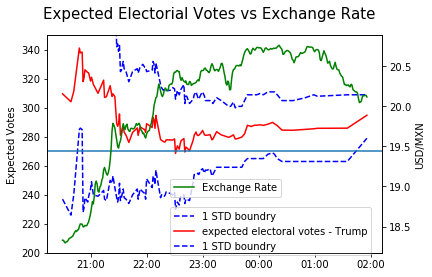

In [91]:
#%%
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='1 STD boundry')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes - Trump')
ax1.plot_date(pred.time, pred.high,'b--', label='1 STD boundry')
plt.ylabel('Expected Votes')
#pylab.legend(loc='lower right')
plt.axhline(y=270)
ax1.legend(loc='center left', bbox_to_anchor=(0.35, 0.1))
ax1.set_ylim([200,350])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('USD/MXN')

#pylab.legend(loc='upper right')
ax2.legend(loc='center left', bbox_to_anchor=(0.35, 0.3))

fig.suptitle('Expected Electorial Votes vs Exchange Rate', fontsize=15)

plt.show()
fig.savefig('results.png')

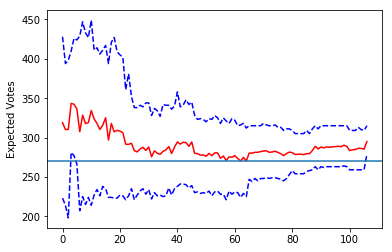

In [84]:
#plot after each update
fig, ax1 = plt.subplots()
ax1.plot(pred.low,'b--', label='95% confidence')
ax1.plot(pred.ave,'r-', label='expected electoral votes')
ax1.plot(pred.high,'b--', label='95% confidence')
plt.ylabel('Expected Votes')
plt.axhline(y=270)
plt.show()

In [126]:
model_hc.summary()

C:\Users\AlexH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.284
Model:                            WLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     4.766
Date:                Fri, 19 Jan 2018   Prob (F-statistic):             0.0496
Time:                        17:03:18   Log-Likelihood:                -35.826
No. Observations:                  14   AIC:                             75.65
Df Residuals:                      12   BIC:                             76.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7579     18.646      0.309      0.763     -34.869      46.385
x1             0.8646      0.396      2.183      0.050       0.002       1.728
==============================================================================
Omnibus:                        0.393   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.496
Skew:                           0.111   Prob(JB):                        0.780
Kurtosis:                       2.105   Cond. No.                     1.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X_dt

In [73]:
Y_dt

92     50.6
141    39.1
143    63.0
155    53.3
169    46.6
182    43.9
208    51.2
216    40.2
231    49.1
234    45.4
236    59.4
264    52.4
266    51.8
273    44.8
280    44.1
281    47.5
284    49.3
286    48.5
287    48.0
288    51.3
289    45.0
290    49.0
Name: trump, dtype: float64

In [121]:
intermediate

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
92,texas,42.5,51.0,4.9,NaN,2016-11-08 21:35:00,50.6,45.5,38,1,65.0
122,florida,48.1,47.5,3.2,NaN,2016-11-08 22:00:00,49.2,47.7,29,1,95.0
133,michigan,48.4,44.2,6.1,NaN,2016-11-08 22:07:00,49.7,45.1,16,1,25.0
137,georgia,45.5,49.5,5.0,NaN,2016-11-08 22:09:00,56.8,40.4,16,1,46.0
138,ohio,45.8,47.7,5.3,NaN,2016-11-08 22:10:00,53.4,42.2,18,1,72.0
139,colorado,47.7,43.6,7.5,NaN,2016-11-08 22:11:00,43.7,48.8,9,1,63.0
140,arizona,45.4,47.6,5.6,NaN,2016-11-08 22:15:00,48.6,46.8,11,1,50.0
141,new mexico,45.7,39.9,13.1,NaN,2016-11-08 22:15:00,39.1,50.6,5,1,54.0
142,north carolina,48.2,47.5,4.3,NaN,2016-11-08 22:15:00,50.5,46.9,15,1,83.0
143,missouri,41.4,51.4,5.7,NaN,2016-11-08 22:16:00,63.0,32.5,10,1,18.0


In [122]:
full_result

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
0,kentucky,37.9,56.1,4.3,1.0,2016-11-08 18:59:00,62.5,32.7,8,0,NaN
1,indiana,40.4,52.0,7.6,1.0,2016-11-08 18:59:00,57.2,37.9,11,0,NaN
2,vermont,60.2,32.8,5.2,0.0,2016-11-08 18:59:00,32.6,61.1,3,0,NaN
3,west virginia,33.3,59.8,5.1,1.0,2016-11-08 19:30:00,68.7,26.5,5,0,NaN
8,massachusetts,58.0,34.6,5.8,0.0,2016-11-08 20:00:00,33.5,60.8,11,0,NaN
9,delaware,52.9,40.4,5.3,0.0,2016-11-08 20:00:00,41.9,53.4,3,0,NaN
10,oklahoma,33.2,59.2,7.6,1.0,2016-11-08 20:00:00,65.3,28.9,7,0,NaN
11,maryland,59.8,34.1,4.4,0.0,2016-11-08 20:00:00,35.3,60.5,10,0,NaN
12,new jersey,53.5,42.0,3.1,0.0,2016-11-08 20:00:00,41.8,55.0,14,0,NaN
13,district of columbia,82.9,12.4,1.8,0.0,2016-11-08 20:00:00,4.1,92.8,3,0,NaN


In [123]:
remain

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
152,new mexico,45.7,39.9,13.1,0.0,2016-11-08 22:21:00,40.0,48.3,5,0,NaN
154,missouri,41.4,51.4,5.7,1.0,2016-11-08 22:25:00,57.1,38.0,10,0,NaN
170,ohio,45.8,47.7,5.3,1.0,2016-11-08 22:36:00,52.1,43.5,18,0,NaN
174,virginia,49.8,44.3,4.7,0.0,2016-11-08 22:40:00,45.0,49.9,13,0,NaN
182,colorado,47.7,43.6,7.5,NaN,2016-11-08 22:50:00,43.9,48.6,9,1,67.0
195,idaho,35.9,55.5,6.7,1.0,2016-11-08 23:00:00,59.2,27.6,4,0,NaN
196,hawaii,57.9,34.1,6.0,0.0,2016-11-08 23:00:00,30.0,62.2,4,0,NaN
197,california,58.5,35.5,4.4,0.0,2016-11-08 23:00:00,32.8,61.6,55,0,NaN
215,north carolina,48.2,47.5,4.3,1.0,2016-11-08 23:11:00,50.5,46.7,15,0,NaN
216,oregon,50.9,41.8,5.9,NaN,2016-11-08 23:15:00,40.2,53.4,7,1,68.0


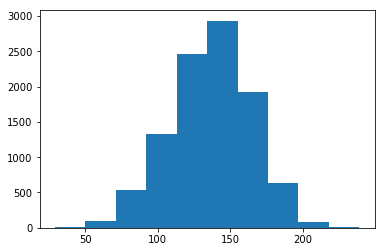

In [127]:
plt.hist(np.dot(result, remain['EV']))
plt.show()

In [116]:
    i=150
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')
    intermediate = intermediate[intermediate.rprpc>15]
    intermediate = intermediate[intermediate.State!='new york']

    X_dt=intermediate['poll_dt']
    Y_dt=intermediate['trump']
    X_dt=sm.add_constant(X_dt)
    model_dt = sm.WLS(Y_dt.values, X_dt.values,weights=intermediate['rprpc']).fit()
    
    #extract parameters
    params_dt = np.random.multivariate_normal(model_dt.params, RegressionResults.cov_params(model_dt), sim_num)
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    X_hc=sm.add_constant(X_hc)
    model_hc = sm.WLS(Y_hc.values, X_hc.values,weights=intermediate['rprpc']).fit()
    
    #extract parameters
    params_hc = np.random.multivariate_normal(model_hc.params, RegressionResults.cov_params(model_hc), sim_num)

    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')
    
    result = np.zeros([sim_num, len(remain)])
    
    for j in range(0, sim_num):
        
        #trump
        result_dt = np.dot(params_dt,sm.add_constant(np.array(remain['poll_dt'])).T)
        result_dt = np.random.normal(result_dt, np.std(model_dt.resid))
        
        #clinton
        result_hc = np.dot(params_hc, sm.add_constant(np.array(remain['poll_hc'])).T) 
        result_hc = np.random.normal(result_hc, np.std(model_hc.resid))
        
        
        result_temp = result_dt>result_hc
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
    
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>=select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=sum(full_result['result'] * full_result['EV'])+ np.dot(result, remain['EV'])

In [128]:
sm.add_constant(np.array(remain['poll_dt'])).T

array([[  1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
          1. ,   1. ,   1. ,   1. ,   1. ,   1. ],
       [ 39.9,  51.4,  47.7,  44.3,  43.6,  55.5,  34.1,  35.5,  47.5,
         41.8,  47.5,  39.9,  48. ,  49.5,  45.9,  37.3,  45.2,  42. ,
         44.3,  43.1,  48.3,  43.9,  47.6,  44.2]])

In [132]:
result_dt[2]

array([ 40.48776785,  53.67398816,  50.73412697,  43.54341837,
        43.93179321,  59.8800156 ,  32.48646728,  35.58880104,
        51.9474603 ,  40.17685035,  54.10102439,  38.73696331,
        51.13460061,  58.37739338,  54.43194535,  32.87305427,
        47.9807286 ,  45.87121138,  48.22260569,  47.11558207,
        56.18120949,  39.2187047 ,  48.5034457 ,  44.57101594])

In [130]:
result_hc

array([[ 47.40709427,  42.17500219,  45.59834045, ...,  48.56400884,
         49.47311301,  45.93165275],
       [ 42.38925544,  48.5274126 ,  43.53208267, ...,  48.33844804,
         44.91543169,  54.38221281],
       [ 43.08041744,  40.99390225,  40.29178891, ...,  42.31275852,
         47.43342408,  45.08220695],
       ..., 
       [ 48.1225905 ,  37.84554951,  38.73853901, ...,  50.11898488,
         46.84561195,  43.08743495],
       [ 51.85558001,  57.03501551,  47.08240091, ...,  45.22744733,
         55.30137996,  50.28997549],
       [ 44.0112161 ,  39.84706905,  49.34380981, ...,  47.79854542,
         44.1599293 ,  46.96402509]])

In [106]:
result_hc

array([[ 41.45264547,  46.1044784 ,  51.68526758, ...,  46.76379291,
         44.25733492,  44.77594232],
       [ 42.60643206,  49.67496102,  43.95009232, ...,  44.52840959,
         51.81697948,  48.70878556],
       [ 37.99240359,  54.57118684,  41.30771412, ...,  50.79390366,
         44.19540646,  51.41386695],
       ..., 
       [ 45.64214926,  37.28513375,  39.22493629, ...,  41.91185387,
         49.54866627,  47.46768378],
       [ 44.33144245,  49.42624617,  46.09110767, ...,  51.14772013,
         48.66516347,  46.36547672],
       [ 37.07237899,  50.25104688,  47.87980646, ...,  45.00585232,
         40.94965998,  39.43887222]])

In [124]:
np.mean(result,axis = 0)

array([ 0.1916,  0.9939,  0.8632,  0.3042,  0.3775,  0.9999,  0.001 ,
        0.0015,  0.7256,  0.1001,  0.7352,  0.0233,  0.8997,  0.9442,
        0.6525,  0.8267,  0.4534,  0.1516,  0.3183,  0.2597,  0.9717,
        0.4243,  0.8703,  0.3844])

In [134]:
np.std(model_dt.resid)

3.1359346872830565

In [142]:
np.random.normal(result_dt, np.std(model_dt.resid))[1]

array([ 44.37326155,  53.51340571,  50.93895156,  44.42928865,
        42.99280553,  63.98350135,  25.30193601,  41.10762056,
        52.86889286,  43.43242605,  54.34887889,  40.03817784,
        50.05806587,  54.74088737,  47.42949873,  44.64750972,
        48.40877974,  51.71250091,  42.33827501,  45.89776106,
        44.0577515 ,  34.72060802,  51.09572809,  40.97975996])